# Transcriptomic Analysis

Run this cell before running the rest of the script. It auto reload the function python script in this juppyternotebook. If not working, please restart the kernel.

In [1]:
%load_ext autoreload
%autoreload 2


#### Initialization

In [2]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from func_transcriptomic_svc import model
import pandas as pd
import matplotlib as mpl
from bar_plot import plot_proportional_bars
# Deifne the font style in later plots
mpl.rcParams['font.family'] = 'Times New Roman'

In [3]:
# Please list the directory here
dataset_dir = "./Dataset/DeseqScaffoldData"
filename = "ScaffoldDeseqTop100.csv"
file_dir = dataset_dir + "/" + filename
metadata_filename = "metadata.csv"
metadata_dir = dataset_dir+"/"+metadata_filename

#### Load dataset

In [4]:
data = pd.read_csv(file_dir, header=0, index_col=0)
metadata = pd.read_csv(metadata_dir, header=0, index_col=0)

The script will automatically run each model listed in the vector 

In [5]:
# model_set = ['svc', 'random_forest', 'logistic_regression', 'elastic_net']
model_set = ["svc"]
run_num = 1000 # how many times of training and verifying in each trial
dropping = "drop_all_4" #dropping all batch4 data in both dataset and metadata

In [6]:
# initialization of storing vector
sensitivity_all = []
specificities_all = []
accuracy_all = []
total_pred = None
total_pred_train = None

Average Accuracy over 1000 runs using svc model: 0.89


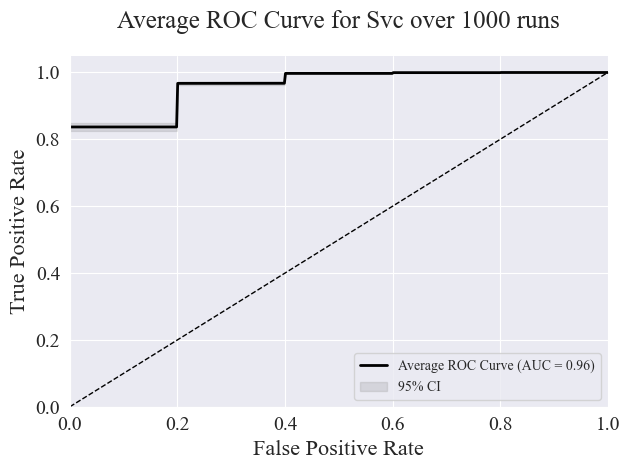

ROC curve saved to: ./temp_roc/roc_svc_runs1000.csv
Prediction finished
Spec for svc
Average Accuracy:  0.889333333333332 

Average Specficities:  0.812399999999997 

Average Sensitivities:  0.9442857142857156 


In [7]:
# Main function loop: 
for model_sel in model_set:
    pred_matrix, training_set_res, accuracies, sensitivities, specificities = model(data, metadata, model_selection=model_sel, run_num=run_num, dropping=dropping)
    results_df = pd.DataFrame({
        'Accuracy': accuracies,
        'Specificity': specificities,
        'Sensitivity': sensitivities
    })
    avg_accuracy = sum(accuracies)/len(accuracies)
    avg_spec = sum(specificities)/len(specificities)
    avg_sens = sum(sensitivities)/len(sensitivities)
    print("Spec for " + model_sel)
    print("Average Accuracy: ", avg_accuracy, "\n")
    print("Average Specficities: ", avg_spec, "\n")
    print("Average Sensitivities: ", avg_sens, "\n")
    accuracy_all.append(accuracies)
    specificities_all.append(specificities)
    sensitivity_all.append(sensitivities)
    if total_pred is None:
        total_pred = pred_matrix
        total_pred_train = training_set_res
    else:
        total_pred = pd.concat([total_pred, pred_matrix], axis=1)
        total_pred_train = pd.concat([total_pred_train, training_set_res], axis=1)

In [8]:
def flatten_concat(list_of_lists):
    return np.concatenate([np.asarray(v).ravel() for v in list_of_lists])

metric_names = ["Accuracy", "Specificity", "Sensitivity"]
metric_data  = [accuracy_all, specificities_all, sensitivity_all]  # 注意顺序与显示一致
accuracy_all = np.array(accuracy_all).flatten()
specificities_all = np.array(specificities_all).flatten()
sensitivity_all = np.array(sensitivity_all).flatten()
out = pd.DataFrame({
    "Accuracy": accuracy_all,
    "Specificity": specificities_all,
    "Sensitivity": sensitivity_all
})

path = "./result/ASSTranscriptomic/ASS.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)
out.to_csv(path, index=True)

/var/folders/8m/ng4jjh0s6ql08w9spsk9c1bc0000gn/T/ipykernel_30274/809201509.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


<Axes: xlabel='Metric', ylabel='Value'>

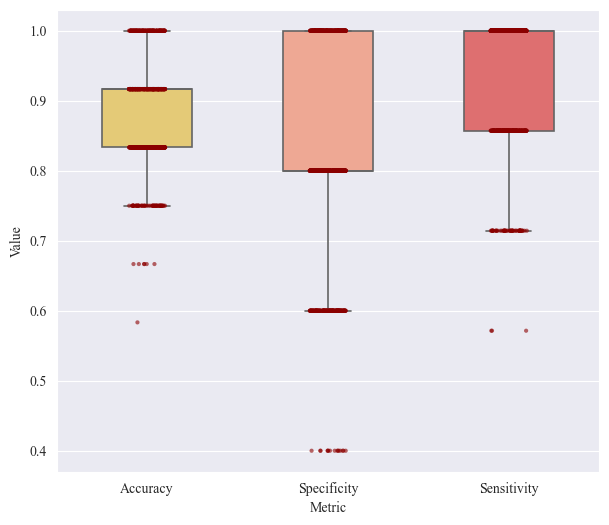

In [9]:
# Adjust the data format for latter plot usage
rows = []
for name, data in zip(metric_names, metric_data):
    vals = flatten_concat(data)        
    rows.append(pd.DataFrame({"Metric": name, "Value": vals}))
df_long = pd.concat(rows, ignore_index=True)

# Boxplot of ASS
plt.figure(figsize=(7, 6))
ax = sns.boxplot(
    x="Metric", y="Value", data=df_long,
    palette=["#f6d365", "#fda085", "#f05d5e"],  
    showfliers=False, width=0.5, linewidth=1.2
)
sns.stripplot(
    x="Metric", y="Value", data=df_long,
    color="darkred", size=3, jitter=True, alpha=0.6, edgecolor="none"
)

In [10]:
# Optional: add horizontal line for the average
means = df_long.groupby("Metric")["Value"].mean()
for i, m in enumerate(metric_names):
    ax.hlines(means[m], i-0.2, i+0.2, colors="darkred", linewidth=2)

In [11]:
ax.set_xlabel("Model Performance Parameter", fontsize=18)
ax.set_ylabel("Performance Metric", fontsize=18)
ax.set_ylim(0, 1.05)
ax.set_title("Performance Across Metrics", fontsize=18)
ax.tick_params(axis='x', labelsize=14)  # 调整 x 轴数字
ax.tick_params(axis='y', labelsize=14)  # 调整 y 轴数字

sns.despine()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Visualization of each sample predicted probability of becoming progressor

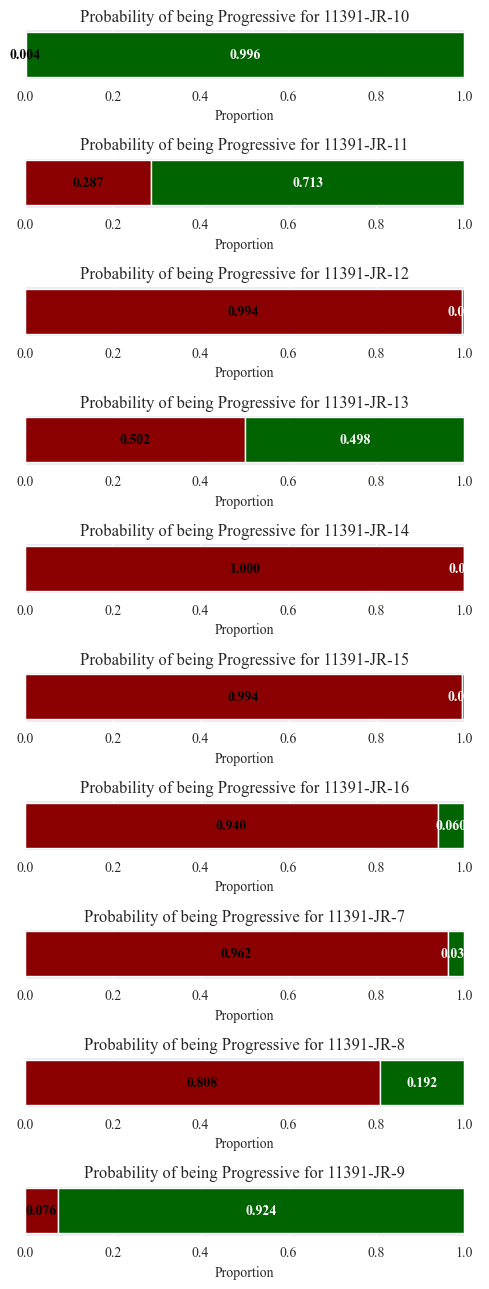

In [12]:
# Plot the bar plot on Batch 4 (Testing set)
Plot_table = total_pred/run_num
Plot_table.to_csv("./result/ProbabilityProgressorTestingSet.csv", index=True)
Plot_table = pd.read_csv("./result/ProbabilityProgressorTestingSet.csv", index_col=0, header=0)
label = model_set
Plot_table.columns = label
Plot_table = Plot_table.T
n = Plot_table.shape[1]  # Samples number plotted
fig, axs = plt.subplots(n, 1, figsize=(5, max(2, 1.3*n)))
if n == 1:
    axs = [axs]
for ax, index in zip(axs.flat, Plot_table):
    data_for_plot = Plot_table[index]
    plot_proportional_bars(data_values=data_for_plot, primary_color="#8B0000", secondary_color="#006400", labels=model_set, ax=ax, sample_name=index)
    ax.set_xlim(0,1.0)
plt.tight_layout()
plt.savefig("./PredictionSamplesOutput.pdf", format="pdf")
plt.show()


## Comparison to Random selected gene signature
To verify the effectiveness of our model, we introduce a SVC model using random selected genes signature for comparison 

In [13]:
from dataclasses import dataclass
from func_random_signature import random_sel

# default run setting if not initialized
@dataclass(frozen=True)
class RunSetting:
    N_RUNS: int = 1000
    N_FEATURES_PER_RUN: int = 100
    TEST_SIZE: float = 0.30
    RANDOM_SEED: int = 42

In [14]:
'''
 N_RUNS: similar to run_num, indicating how many runs in one trial
 N_FEATURES_PER_RUN: the number of gene signatures used in the random model. Our SVC model uses 100.
 TEST_SIZE: the ratio to split training set and testing set. In our dataset in SVC, 0.3 is used.
 RANDOM_SEED: seed used for randomization
'''
cfg = RunSetting(N_RUNS = 1000,
    N_FEATURES_PER_RUN = 10,
    TEST_SIZE = 0.30,
    RANDOM_SEED= 42)
param_grid = [
            {"kernel": ["linear"], "C": [0.1, 1, 10], "gamma": ["scale", "auto"]},
            {
                "kernel": ["poly"],
                "degree": [2, 3, 4, 5],
                "gamma": ["scale", "auto"],
                "C": [0.1, 1, 10],
            },
        ]
data = pd.read_csv(file_dir, header=0, index_col=0)
metadata = pd.read_csv(metadata_dir, header=0, index_col=0)
[performanceMetric, rocData] = random_sel(data=data, metadata=metadata, runSetting=cfg,param_grid=param_grid )
OUTDIR = "./result/random"
os.makedirs(OUTDIR, exist_ok=True)

# All related file saved into OUTDIR directory
random_perf_path = os.path.join(OUTDIR, "randomPerfMetric.csv")
performanceMetric.to_csv(random_perf_path, index=False)
random_roc_path = os.path.join(OUTDIR, "randomRocData.csv")
rocData.to_csv(random_roc_path, index=False)

print(f"Files saved to {random_perf_path} and {random_roc_path}")


/Users/JiangYIfei/Desktop/python_env/py311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/JiangYIfei/Desktop/python_env/py311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/JiangYIfei/Desktop/python_env/py311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/JiangYIfei/Desktop/python_env/py311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

===== SVC  =====
N_RUNS:             1000
Average Accuracy:    0.8066
Average Specificity: 0.7812
Average Sensitivity: 0.8247
Average AUC:         0.8906
Files saved to ./result/random/randomPerfMetric.csv and ./result/random/randomRocData.csv


## ROC curve comparison across three datasets

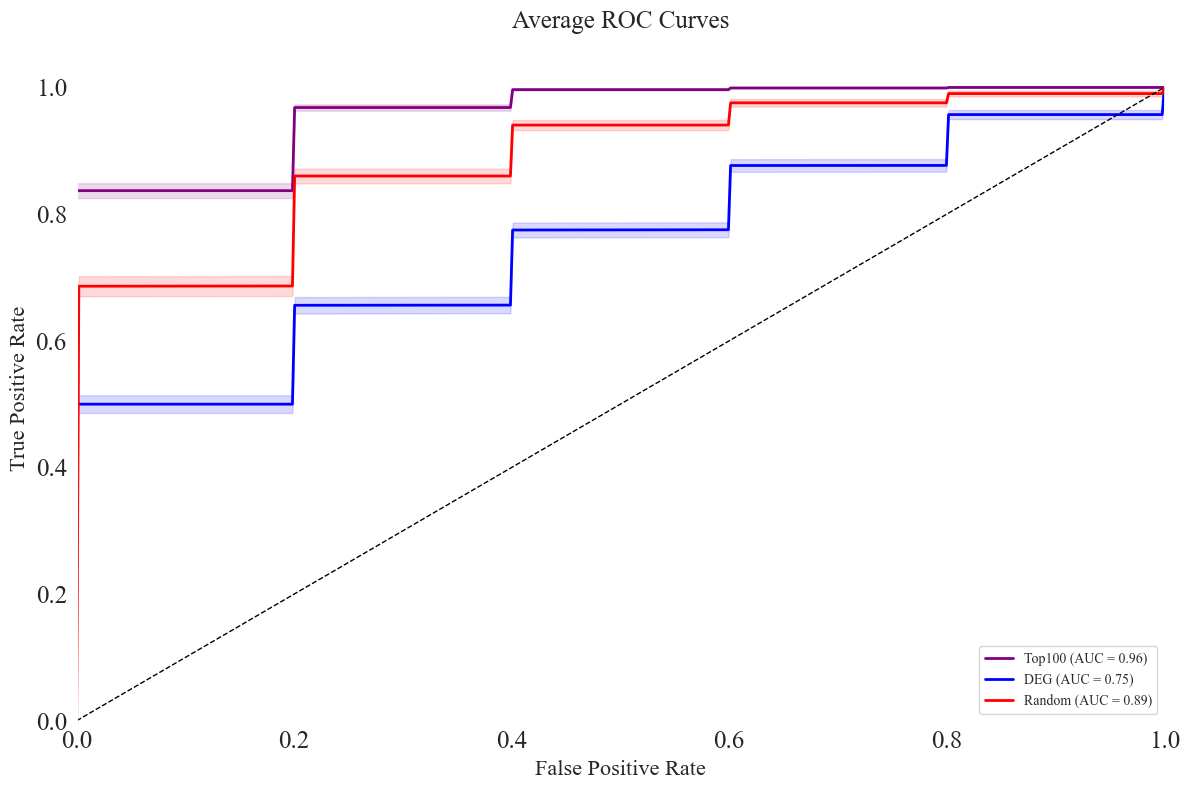

0

In [15]:
from func_roc_plot import roc_plot
# This function is able to read the data saved in different directory, only need to provide directory address and assign a label on it.
roc_files = {
    "Top100": "./temp_roc/roc_oursig_1000.csv",
    "DEG": "./temp_roc/roc_deg_1000.csv",
    "Random": "./result/random/randomRocData.csv",
}

colors = {
    "Top100": "purple",
    "DEG": "blue",
    "Random": "red",
}
roc_plot(roc_files, colors, out_pdf="./ROC_figure.pdf")

## Comparison of performance metric across 3 datasets 

/Users/JiangYIfei/Desktop/college/UM/lab/T1D_Prediction_github/func_metric_plot.py:62: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


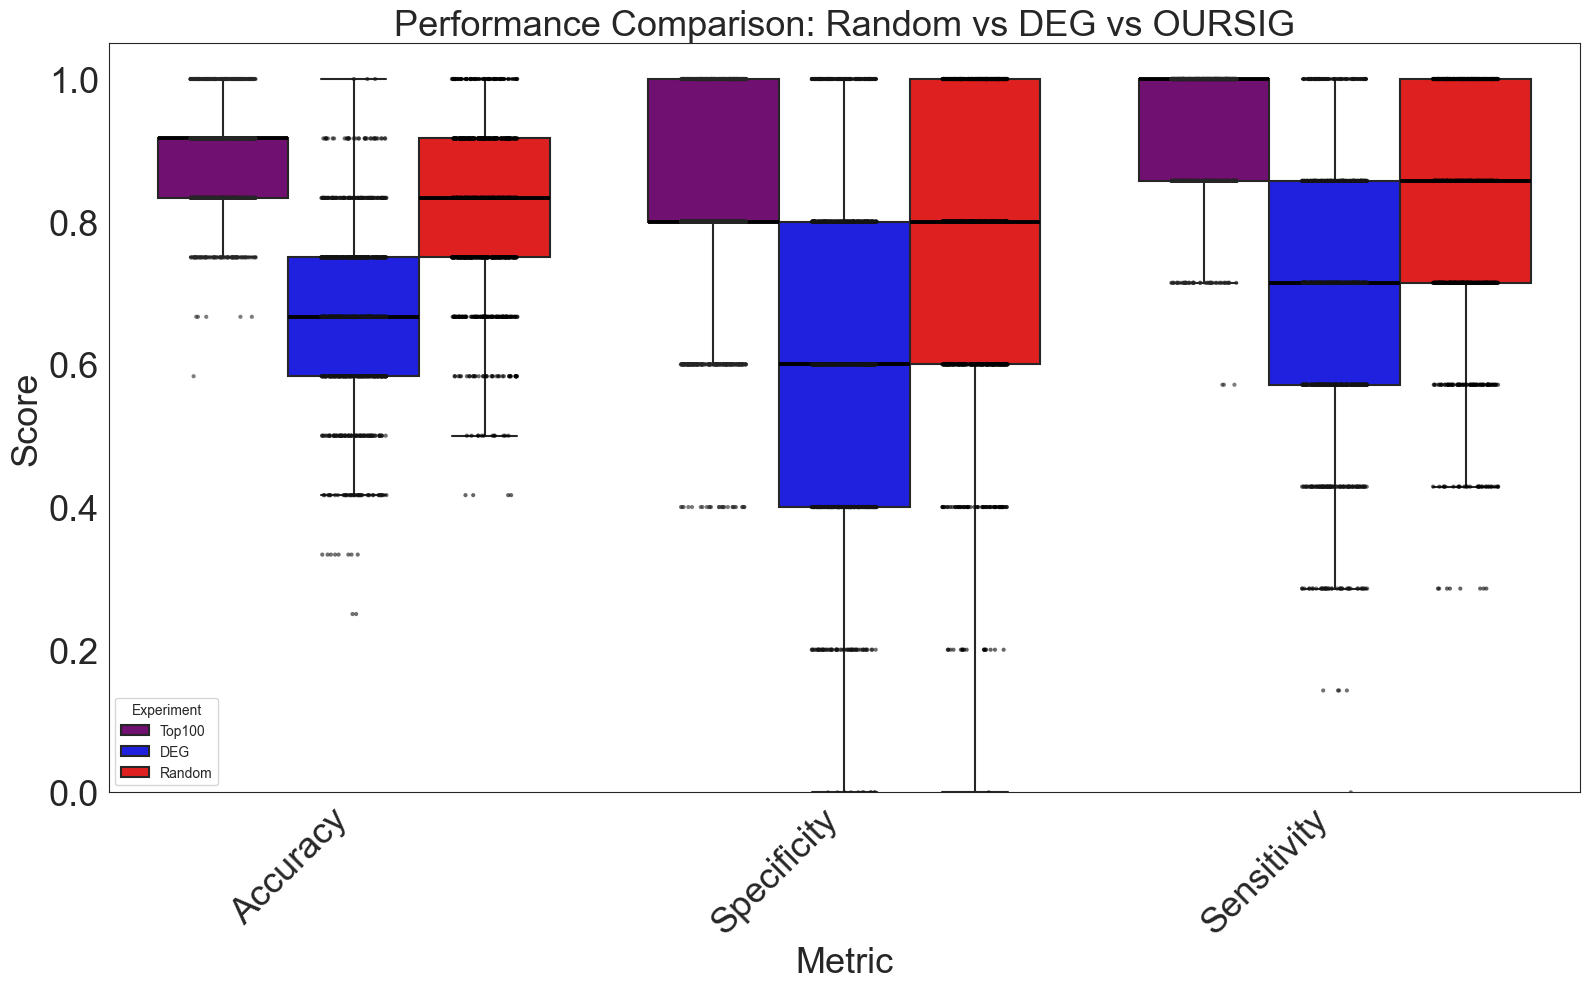

In [16]:
from func_metric_plot import metric_boxplot
metric_files = {
    "Top100": "./result/ASSTranscriptomic/OURSIG_ASS.csv",
    "DEG": "./result/ASSTranscriptomic/DEG_ASS.csv",
    "Random": "./result/random/randomPerfMetric.csv",
}

palette_boxes = {
    "Top100": "purple",
    "DEG": "blue",
    "Random": "red",
}

df_long = metric_boxplot(
    metric_files, palette_boxes,
    cols=("Accuracy","Specificity","Sensitivity"),
    title="Performance Comparison: Random vs DEG vs OURSIG",
    out_pdf="ASS_figure.pdf"
)

